In [1]:
import fastbook
fastbook.setup_book()

E:\Conda\envs\fastai2-env\lib\site-packages\fastbook\__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
from fastbook import *
from fastai.vision.all import *

In [37]:
path = Path(r'C:\Users\Msi\.fastai\data\oxford-iiit-pet\oxford-iiit-pet')

In [38]:
Path.BASE_PATH = path

In [39]:
(path/'images').ls()

(#7393) [Path('images/Abyssinian_1.jpg'),Path('images/Abyssinian_10.jpg'),Path('images/Abyssinian_100.jpg'),Path('images/Abyssinian_100.mat'),Path('images/Abyssinian_101.jpg'),Path('images/Abyssinian_101.mat'),Path('images/Abyssinian_102.jpg'),Path('images/Abyssinian_102.mat'),Path('images/Abyssinian_103.jpg'),Path('images/Abyssinian_104.jpg')...]

In [40]:
fname = (path/'images').ls()[0]

In [53]:
re.findall(r'(\w+)_\d+.jpg$',fname.name)

['Abyssinian']

In [95]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=42),
                get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/'images', num_workers=0, bs=64)

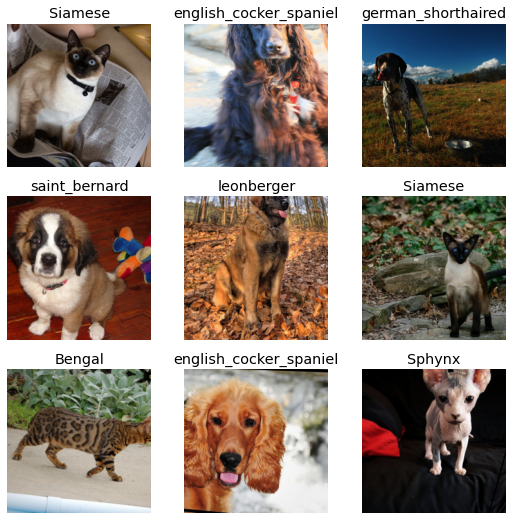

In [74]:
dls.show_batch(nrows=3)

In [71]:
pets.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\Msi\.fastai\data\oxford-iiit-pet\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\Msi\.fastai\data\oxford-iiit-pet\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30, dtype=torch.int32)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(30, dtype=torch.int32))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflect

In [77]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.model.cuda()
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.507946,0.303677,0.090663,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.509553,0.331113,0.102842,02:06
1,0.306217,0.207959,0.066306,01:43


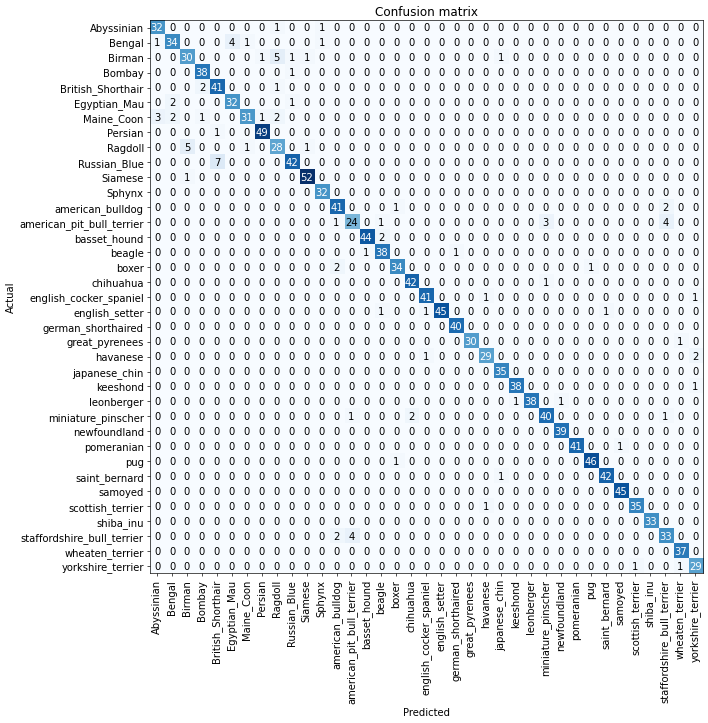

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [80]:
interp.most_confused(min_val=4)

[('Russian_Blue', 'British_Shorthair', 7),
 ('Birman', 'Ragdoll', 5),
 ('Ragdoll', 'Birman', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4)]

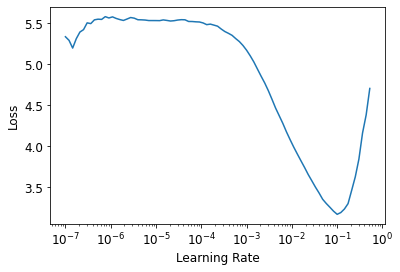

In [81]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.model.cuda()
lr_min,lr_steep = learn.lr_find()

In [82]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.63e-03


In [88]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.model.cuda()
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.311140,0.319448,0.102165,01:30


epoch,train_loss,valid_loss,error_rate,time
0,0.518499,0.340564,0.106901,01:43
1,0.328491,0.215626,0.064276,01:40


In [96]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.model.cuda()
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.143823,0.327606,0.105548,01:26
1,0.528827,0.244265,0.081191,01:26
2,0.329563,0.208127,0.069689,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.253143,0.202385,0.069012,01:39
1,0.237887,0.195525,0.062246,01:39
2,0.237158,0.197464,0.062246,01:39
3,0.212947,0.200933,0.061570,01:39
4,0.193316,0.194290,0.062923,01:42
5,0.165289,0.189004,0.056157,01:41
6,0.171418,0.189686,0.059540,01:39
7,0.144900,0.189077,0.054804,01:39
8,0.125879,0.188581,0.059540,01:39
9,0.141531,0.187483,0.056834,01:39


In [98]:
learn.export(fname='petbreeds.pkl')

In [6]:
learn_inf = load_learner(Path.cwd()/'models'/'petbreeds.pkl')

In [7]:
learn_inf.dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

In [11]:
learn_inf.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
learn_inf.save(Path.cwd())

Path('E:/Environments/fastai2.pth')